In this notebook, we will be working through [Building makemore Part 2: Training Diagnostics](https://www.youtube.com/watch?v=P6sfmUTpUmc) by Andrej Karpathy. This is the fourth video in the "Neural Networks: Zero to Hero" series and covers part 2 of it.

In this video we will look at diagnostic tools that we can use to see if our models are training optimally.

**Why training diagnostics matter:** When a neural network underperforms, the loss number alone doesn't tell you _why_. Is the learning rate too high? Are gradients vanishing in deep layers? Are neurons saturating? Training diagnostics give us visibility into the internal dynamics of the network — activations, gradients, and parameter updates — so we can distinguish between a model that's learning healthily and one that's silently broken. This is especially important as networks get deeper, where problems like vanishing/exploding gradients can make training appear to work (the loss decreases) while the network is actually only learning in a subset of its layers.


# Section 1: "Pytorchify" Our Model

In the previous notebook, we had a very haphazard way of creating the model. Lets first package those into layers similar to how pytorch does it.

The idea here is to move from "raw tensor math" to **modular, composable layers** — each layer is a callable object that stores its own parameters and output. This is exactly the design pattern PyTorch uses with `torch.nn.Module`: each layer knows how to do its forward pass, what parameters it owns, and (via autograd) how to compute gradients. By adopting this pattern now, we accomplish two things:

1. **Cleaner code** — the forward pass becomes a simple loop through layers instead of a wall of matrix multiplications
2. **Diagnostic access** — each layer stores `self.out`, so after training we can inspect activations and gradients at every point in the network

Note that our custom classes below are simplified versions of PyTorch's `nn.Linear`, `nn.BatchNorm1d`, and `nn.Tanh`. They don't inherit from `nn.Module` (so no automatic parameter registration, `.to(device)`, `.eval()` mode toggling, etc.), but the core math is identical.


In [146]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

In [22]:
# lets copy over some stuff from the previous notebook

# utility to read dataset
DATASET_PATH = '../names.txt'
SPECIAL_TOKEN = "."
device = 'cuda' if torch.cuda.is_available() else 'cpu'
g = torch.Generator(device=device).manual_seed(2147483647)

def get_dataset():
    with open(DATASET_PATH, 'r') as f:
        rows = [row.strip() for row in f.readlines()]
    return rows

# Load dataset
words = get_dataset()
print(f"{len(words)} names loaded")
print(f"Examples: {words[:8]}")

# Build character mappings — identical to lesson 2
# '.' is our special start/end token at index 0, then a=1, b=2, ..., z=26
all_characters = [SPECIAL_TOKEN] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(all_characters)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")
print(f"Mappings: {itos}")
print(f"Running on: {device}")

32033 names loaded
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Vocabulary size: 27
Mappings: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Running on: cuda


In [6]:
def build_dataset(words, block_size=3):
    """
    Convert a list of words into (X, Y) tensors for training.

    X shape: (N, block_size) — each row is a context window of character indices
    Y shape: (N,) — each element is the target character index

    This function will be called three times: once each for train, val, and test splits.
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + SPECIAL_TOKEN:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

# 80/10/10 split at the word level
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=3)     # training
Xdev, Ydev = build_dataset(words[n1:n2], block_size=3)  # validation ("dev" set)
Xte, Yte = build_dataset(words[n2:], block_size=3)      # test

Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

print(f"Training:   {Xtr.shape[0]:>7,} examples from {n1:,} names")
print(f"Validation: {Xdev.shape[0]:>7,} examples from {n2-n1:,} names")
print(f"Test:       {Xte.shape[0]:>7,} examples from {len(words)-n2:,} names")

Training:   182,625 examples from 25,626 names
Validation:  22,655 examples from 3,203 names
Test:        22,866 examples from 3,204 names


### Reference: old-style model from the previous notebook

The cell below contains the raw-tensor implementation from the previous notebook (batch norm lesson). It's kept here commented-out as a reference point so we can compare the "before" and "after" as we refactor into modular layers. Notice how the forward pass is a single monolithic block of operations — by the end of this section, we'll replace that with a clean `for layer in layers` loop.


In [7]:
# Now this is the code we had at the end of the previous notebook

def get_params(embed_dim, block_size, n_hidden):

    tanh_gain = 5./3  # correction factor for tanh squashing variance

    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g) * (tanh_gain / (embed_dim * block_size) ** 0.5)  # Kaiming with tanh gain
    b1 = torch.randn(n_hidden,                        generator=g) * 0.01  # small, near zero
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * (1 / (n_hidden) ** 0.5)  # Xavier (gain=1, no activation)
    b2 = torch.randn(vocab_size,                       generator=g) * 0.01  # small, near zero

    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))

    # add tracking variables which are NOT part of the training and thus dont receive gradients
    bnstd_running = torch.ones((1, n_hidden))
    bnmean_running = torch.zeros((1, n_hidden))

    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True

    return bnstd_running, bnmean_running, parameters

def train_model(params, n_steps=200000, batch_size=32):

    bnstd_running, bnmean_running, parameters = params
    C, W1, b1, W2, b2, bngain, bnbias = parameters

    stepi = []
    lossi = []
    loglossi = []

    pbar = tqdm(range(n_steps), desc="Training")
    for i in pbar:
        # Mini-batch: randomly sample 32 examples
        ixds = torch.randint(0, Xtr.shape[0], (batch_size,))
        mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

        # Forward pass
        emb = C[mini_batch_inp]                                        # (32, 3, 10)
        emb_cat = emb.view(emb.shape[0], -1)                            # (32, 30)
        hidden_layer_preactivation = emb_cat @ W1 + b1                  # (32, 200)

        # CONVERT hidden_layer_preactivation to unit gaussian
        _mean = hidden_layer_preactivation.mean(axis=0, keepdim=True) # (1, 200) take mean across the samples in the mini batch
        _std = hidden_layer_preactivation.std(axis=0, keepdim=True) # (1, 200) take std across the samples in the mini batch

        hidden_layer_preactivation = (hidden_layer_preactivation - _mean) / _std # convert to unit gaussian

        # move the running average slightly based on the currnet mean and std directions
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * _mean
            bnstd_running = 0.999 * bnstd_running + 0.001 * _std

        # scale and shift
        hidden_layer_preactivation = hidden_layer_preactivation*bngain + bnbias

        h = torch.tanh(hidden_layer_preactivation)  # (32, 200)
        logits = h @ W2 + b2                                           # (32, 27)
        loss = F.cross_entropy(logits, mini_batch_target)

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Learning rate step decay: 0.1 for first 100K steps, then 0.01
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # Track loss
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())

        if i % 10 == 0:
            pbar.set_postfix(loss=f"{loss.data:.4f}")

    return stepi, lossi, loglossi, hidden_layer_preactivation, h, logits, bnmean_running, bnstd_running

# now we can use these running mean and std during eval
@torch.no_grad()
def eval_loss(X, Y, params, embed_dim, block_size):

    bnstd_running, bnmean_running, parameters = params
    C, W1, b1, W2, b2, bngain, bnbias = parameters

    emb = C[X]
    emb_cat = emb.view(emb.shape[0], -1)

    hidden_layer_preactivation = emb_cat @ W1 + b1
    hidden_layer_preactivation = (hidden_layer_preactivation - bnmean_running) / bnstd_running
    hidden_layer_preactivation = hidden_layer_preactivation*bngain + bnbias

    h = torch.tanh(hidden_layer_preactivation)  # (32, 200)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# bnstd_running, bnmean_running, parameters = get_params(embed_dim, block_size, n_hidden)

# stepi, lossi, loglossi, hidden_layer_preactivation, h, logits, bnmean_running, bnstd_running = \
#     train_model([bnstd_running, bnmean_running, parameters])

# print(f"Final Training loss: {eval_loss(Xtr, Ytr,[bnstd_running, bnmean_running, parameters], embed_dim, block_size)}, \
#     Validation Loss: {eval_loss(Xdev, Ydev, [bnstd_running, bnmean_running, parameters], embed_dim, block_size)}")

### `Linear` — our version of `torch.nn.Linear`

This layer computes `y = x @ W + b`. The key design choices:

- **Kaiming initialization** — we divide the random weights by `√fan_in` (the number of input features). This keeps the variance of the output roughly equal to the variance of the input, preventing activations from exploding or vanishing as data flows through the network. This is the same initialization PyTorch uses by default for `nn.Linear`.
- **`self.out`** — we store the output on the layer object so we can inspect it later for diagnostics. This is not something PyTorch does by default (you'd use forward hooks for that), but it's very convenient for learning.
- **No bias by default in some configurations** — when BatchNorm follows a Linear layer, the bias is redundant because BatchNorm subtracts the mean anyway (and then adds its own learnable bias `β`). That's why `setup_model` can pass `bias=False`.


In [177]:
# Create Linear Layer

class Linear:

    def __init__(self, num_input_features, num_output_features, bias=True, device='cpu', ignore_scaling=False):

        initialization_factor = num_input_features ** 0.5 # kaiming he initialization

        # just adding this to get non properly scaled linear layers
        # which should show up as issues during our diagnostic
        if ignore_scaling:
            initialization_factor = 1.0

        self.weights = \
            torch.randn((num_input_features, num_output_features), generator=g, device=device) / initialization_factor
        self.bias = torch.zeros(num_output_features, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights # note that we keep the output under self so that we can access it later for diagnostics
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

    def __repr__(self):
        return f"Linear {tuple(list(self.weights.shape))})"

### `BatchNorm1d` — our version of `torch.nn.BatchNorm1d`

Batch normalization, introduced in [Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167), normalizes each feature across the mini-batch to have zero mean and unit variance, then applies a learnable scale (`γ`) and shift (`β`). Key things to note:

- **Training vs. inference behavior** — during training, we compute mean/variance from the current mini-batch. During inference, we use the exponential moving averages (EMAs) accumulated during training. This dual behavior is why there's a `self.training` flag — and why in PyTorch you must call `model.eval()` before inference.
- **Why EMA and not just a simple average?** — We could average all training-set statistics at the end, but EMA is computed on-the-fly and adapts as the model's parameters change during training. The EMA with momentum 0.1 means each update blends 10% of the current batch stats with 90% of the running estimate.
- **`eps`** — a small constant (1e-5) added inside the square root to prevent division by zero when variance is near zero.
- **Why BatchNorm helps** — it reduces "internal covariate shift" (the original motivation), but more practically it acts as a form of regularization (each sample's normalization depends on what other samples are in the batch — a source of noise) and allows higher learning rates by keeping activations in a well-behaved range.


In [46]:
# Create batchnorm layer

class BatchNorm1d:

    def __init__(self, num_input_features, momentum=0.1, eps=1e-5, device='cpu'):

        self.eps = eps
        self.momentum = momentum

        # learnable scale and shift parameters (gain and bias)
        self.gamma = torch.ones(num_input_features, device=device)
        self.beta = torch.zeros(num_input_features, device=device)

        # Exponential moving average (EMA) tracking
        self.running_mean = torch.zeros(num_input_features, device=device)
        self.runnins_vars = torch.ones(num_input_features, device=device)

        self.training = True # batchnorm behaves different during training vs during inference/eval

    def __call__(self, x: torch.Tensor):

        if self.training:
            xmean = x.mean(axis=0, keepdim=True) # mean across batch
            xvars = x.var(axis=0, keepdim=True) # variance across batch
        else:
            xmean = self.running_mean
            xvars = self.runnins_vars

        # normalize
        self.out = (x - xmean) / torch.sqrt(xvars + self.eps)

        # scale and shift
        self.out = self.gamma * self.out + self.beta

        # EMA update

        if self.training:
            with torch.no_grad(): # these are not learnable params
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_vars = self.running_vars * (1 - self.momentum) + xvars * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

    def __repr__(self):
        return f"BatchNorm1d {tuple(list(self.gamma.shape))})"

### `Tanh` — activation function layer

Wrapping `torch.tanh` in a class might seem like overkill, but it serves the same purpose as the other layers: it stores `self.out` so we can inspect post-activation values during diagnostics. Later we'll use this to check for **saturation** — if too many tanh outputs are near ±1, gradients in those regions are near zero, and learning stalls (the "dead neuron" problem for tanh).


In [50]:
# Tanh

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

    def __repr__(self):
        return "Tanh ()"

### `setup_model` — composing layers into a network

This function builds the full network as a flat list of layers: `[Linear → BatchNorm → Tanh] × N → Linear`. This is equivalent to `torch.nn.Sequential` in PyTorch. A few important details:

- **`output_gain = 0.1`** — the output layer's weights are scaled down by 10×, so the initial logits are small and the softmax distribution starts nearly uniform. Without this, the model would start overconfident on random classes, producing a high initial loss and large gradients that can destabilize early training.
- **`tanh_gain = 5/3 ≈ 1.667`** — this compensates for tanh squashing the variance of its output. If input to tanh is standard normal, the output variance is less than 1 (because tanh compresses values toward ±1). The gain factor `5/3` is the empirically-derived correction from the [Kaiming He paper](https://arxiv.org/abs/1502.01852) that keeps the variance roughly stable through tanh layers. Note: this gain is applied _on top of_ the Kaiming `1/√fan_in` already in the `Linear` class.
- **Why separate `hidden_layers`?** — the gain adjustment only applies to Linear layers followed by tanh, _not_ to the output layer (which has no activation). Separating them lets us selectively apply the gain.


In [193]:
# make a fn to create a stack of layers

def setup_model(embed_dim,
                block_size,
                n_hidden_per_layer,
                num_hidden_layers = 4,
                bias = True,
                tanh = True,
                batchnorm = True,
                output_gain = 0.1,
                tanh_gain = 5./3,
                device = 'cpu',
                ignore_scaling = False
                ):

    # create embedding lookup

    C = torch.randn((vocab_size, embed_dim), generator=g, device=device)

    flattened_input_features = embed_dim * block_size

    layers = []
    hidden_layers = []
    # setup input

    input_layer = Linear(flattened_input_features, n_hidden_per_layer, bias=bias, device=device, ignore_scaling=ignore_scaling)
    layers.append(input_layer)
    if batchnorm:
        x = BatchNorm1d(n_hidden_per_layer, device=device, ignore_scaling=ignore_scaling)
        layers.append(x)
    if tanh:
        x = Tanh()
        layers.append(x)

    # setup hidden
    for _ in range(num_hidden_layers):
        x = Linear(n_hidden_per_layer, n_hidden_per_layer, bias=bias, device=device, ignore_scaling=ignore_scaling)
        hidden_layers.append(x)
        if batchnorm:
            x = BatchNorm1d(n_hidden_per_layer, device=device)
            hidden_layers.append(x)
        if tanh:
            x = Tanh()
            hidden_layers.append(x)

    layers.extend(hidden_layers)

    # setup output layer
    output_layer = Linear(n_hidden_per_layer, vocab_size, bias=bias, device=device)
    layers.append(output_layer)

    # Now lets play with the gain a bit to see how it affects activations and gradients

    with torch.no_grad():

        # make last layer less confident for starting with uniform distribution
        output_layer.weights *= output_gain

        if tanh:
            for layer in hidden_layers: # if linear layers are followed by tanh, apply tanh gain
                if isinstance(layer, Linear):
                    layer.weights *= tanh_gain

    parameters = [C] + [param for layer in layers for param in layer.parameters()]
    print(f"Total number of parameters in model: {sum(p.nelement() for p in parameters)}")

    for p in parameters:
        p.requires_grad = True

    return C, layers, parameters

## Training loop with diagnostics

Lets also port over our training model code with a few changes -

1. **Retaining intermediate gradients** — By default, PyTorch only keeps gradients for "leaf" tensors (parameters you created directly). Intermediate results (like the output of a hidden layer) have their gradients discarded after `backward()` to save memory. Calling `retain_grad()` on `layer.out` tells PyTorch to keep those gradients so we can inspect them later. In production code, you'd use **forward/backward hooks** (`register_forward_hook`, `register_full_backward_hook`) instead, but `retain_grad()` is simpler for learning.

2. **Cleaner forward pass** — instead of manually writing out each matrix multiplication, we loop through our layer objects: `for layer in layers: x = layer(x)`. This is exactly what `nn.Sequential.__call__` does internally.

3. **Update-to-data ratio** — This is the key diagnostic Karpathy introduces. For each parameter tensor, we compute:

$$\text{ratio} = \frac{\text{std}(\text{lr} \times \nabla p)}{\text{std}(p)}$$

This tells us how large each gradient update is _relative to the parameter values themselves_. Karpathy's rule of thumb: this ratio should be roughly **1e-3** (i.e., the update is about 1/1000th the size of the parameter). If it's much larger, learning is unstable (parameters are being yanked around too aggressively). If it's much smaller, the parameters are barely changing and learning is too slow. This is a much more informative signal than just watching the loss curve.


In [137]:
def train_model(C, layers, parameters, n_steps = 200000, batch_size = 32, lr = 0.1, decayed_lr = 0.01):

    stepi = []
    lossi = []
    loglossi = []
    update_to_data_ratio = []

    pbar = tqdm(range(n_steps), desc="Training")
    for i in pbar:
        # Mini-batch: randomly sample 32 examples
        ixds = torch.randint(0, Xtr.shape[0], (batch_size,))
        mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

        # Forward pass
        emb = C[mini_batch_inp]
        x = emb.view(emb.shape[0], -1)

        for layer in layers:
            x = layer(x)

        # loss function
        loss = F.cross_entropy(x, mini_batch_target)

        # Backward pass

        # Retain gradients for intermediate layers for diagnostics
        for layer in layers:
            layer.out.retain_grad()

        for p in parameters:
            p.grad = None
        loss.backward()

        # Learning rate step decay: 0.1 for first 100K steps, then 0.01
        lr = lr if i < 100000 else decayed_lr
        for p in parameters:
            p.data += -lr * p.grad

        # Track loss
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())

        if i % 10 == 0:
            pbar.set_postfix(loss=f"{loss.data:.4f}")

        with torch.no_grad():
            tmp = []
            for p in parameters:

                update_std = (lr * p.grad).std()
                data_std = p.data.std()
                ratio = update_std / data_std
                tmp.append(ratio.log10().item())
            update_to_data_ratio.append(tmp)
            # update_to_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    return stepi, lossi, loglossi, update_to_data_ratio, layers, parameters


# Section 2: Creating Diagnostic Plots

Here we create a few diagnostic plots which will help with understanding how well a model is training.

These are the four core diagnostics Karpathy walks through in the video. Together, they give a complete picture of the network's health:

| Diagnostic                       | What it shows                                                | What to look for                                                                                             |
| -------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Activation distribution**      | Values flowing _forward_ through each layer                  | Should be roughly Gaussian, centered near 0. If values pile up at ±1, tanh is saturating.                    |
| **Gradient distribution**        | Values flowing _backward_ through each layer                 | Should have similar scale across layers. If gradients shrink in earlier layers → vanishing gradient problem. |
| **Weight gradient distribution** | How much each weight matrix wants to change                  | Should be roughly the same order of magnitude across layers.                                                 |
| **Update-to-data ratio**         | Size of the actual parameter update vs. the parameter itself | Should hover around 1e-3. Much larger → unstable. Much smaller → learning too slowly.                        |


### Activation distribution

This plots a histogram of the output values at each Tanh layer. We're checking for **saturation**: when tanh outputs cluster near ±1 (above the 0.97 threshold), those neurons are in the flat region of tanh where the gradient is nearly zero. A saturated neuron can barely learn — it's effectively "dead" for that training step.

**Healthy activations** look like a smooth bell curve between -1 and +1 with most values well inside the ±0.97 range. **Unhealthy activations** show a bimodal distribution with peaks at ±1 (the "U-shape"), meaning the pre-activation values are too large and tanh is squashing everything to the extremes. This is exactly the kind of problem that proper weight initialization (Kaiming) and BatchNorm are designed to prevent.


In [81]:
def plot_activation_distribution(layers, layer_to_plot = Tanh):

    # visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, layer_to_plot):
            t = layer.out # this is the activation of the layer
            t = t.to(device="cpu")
            layer_name = layer.__class__.__name__
            saturation_count = (t.abs() > 0.97).float().mean()*100

            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer_name, t.mean(), t.std(), saturation_count))

            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer_name}')
    plt.legend(legends);
    plt.title('activation distribution')
    plt.show()


### Activation Gradient distribution

This is the backward-pass counterpart to the activation plot above. Instead of looking at `layer.out`, we look at `layer.out.grad` — the gradient of the loss with respect to each layer's output.

**What we're watching for:** the gradients should have roughly similar standard deviations across all layers. If the std shrinks dramatically in earlier layers (closer to the input), we have a **vanishing gradient problem** — those layers are receiving almost no learning signal. If it grows, we have **exploding gradients**.

In a well-initialized network with BatchNorm, the gradient magnitudes should be relatively uniform across layers, because BatchNorm helps stabilize both the forward and backward pass.


In [97]:
def plot_gradient_distribution(layers, layer_to_plot = Tanh):

    # visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, layer_to_plot):
            t = layer.out.grad # this is the gradient flowing through the layer
            t = t.to(device="cpu")
            layer_name = layer.__class__.__name__

            print('layer %d (%10s): mean %+f, std %f' % (i, layer_name, t.mean(), t.std()))

            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer_name}')
    plt.legend(legends);
    plt.title('Gradient distribution')
    plt.show()

### Weight gradient distribution

While the previous plot showed gradients flowing through activations, this one looks at the gradients on the **weight matrices themselves** — i.e., `p.grad` for each 2D parameter tensor. This tells us how much each weight matrix "wants" to change.

The key metric printed is the **grad:data ratio** (`grad.std() / param.std()`). If one layer's weights have gradients that are orders of magnitude smaller than other layers', that layer is learning much more slowly — a sign of poor initialization or vanishing gradients reaching that layer.

Note: we only plot 2D parameters (weight matrices), skipping 1D parameters (biases, BatchNorm gamma/beta) since the weight matrices contain the bulk of the model's capacity and are more informative for diagnostics.


In [171]:
def plot_weights_gradient_distribution(parameters):

    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(parameters):
        t = p.grad
        t = t.to(device="cpu")
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')
    plt.show()


### Update-to-data ratio over time

This is arguably the most important diagnostic. It plots, for each weight matrix, the ratio of `(lr × grad.std()) / param.std()` across all training steps.

The black horizontal line at -3 (on the log10 scale) marks the **1e-3 sweet spot**. Karpathy's heuristic:

- **Ratio ≈ 1e-3** — healthy. Each update nudges the parameters by about 0.1% of their magnitude.
- **Ratio >> 1e-3** (e.g., 1e-1) — the learning rate is too high for this layer, causing large, destabilizing jumps.
- **Ratio << 1e-3** (e.g., 1e-5) — this layer is barely learning. Either the learning rate is too low or gradients are vanishing before they reach this layer.

Unlike the loss curve, this diagnostic tells you _which layers_ are learning too fast or too slowly, letting you diagnose initialization and learning rate problems layer by layer.


In [172]:
def plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio, n_steps_mean=500):
    plt.figure(figsize=(20, 4))
    legends = []
    np_arr = np.array(update_to_data_ratio)[n_steps_mean:].mean(axis=0)
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            print('param %d | mean (last 500 steps) %+f' % (i, np_arr[i].mean().item()))
            plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
            legends.append('param %d' % i)
    plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);
    plt.show()

### Aside: Why plots for both activation gradient and weight gradient?

When watching the video, I was a little confused as to why we need plots for both. Here is the reason —

They measure **different quantities** that can diverge from each other. To see why, consider what happens in a single Linear layer computing `h = x @ W`:

- **`layer.out.grad`** = `∂L/∂h` — the gradient of the loss with respect to the layer's **output activation**. This is the signal flowing backward through the network.
- **`W.grad`** = `∂L/∂W` — the gradient of the loss with respect to the **weight matrix**. This is what actually gets used in the SGD update step.

The chain rule connects them:

$$\frac{\partial L}{\partial W} = x^T \cdot \frac{\partial L}{\partial h}$$

The weight gradient is the **product of two things**: the input `x` from the forward pass, and the activation gradient `∂L/∂h` from the backward pass. So even if the activation gradients are perfectly healthy, the weight gradients can be off if the forward-pass inputs have unusual scale.

#### Concrete example with a 3-layer network

Consider `h1 = x @ W1`, `h2 = h1 @ W2`, `h3 = h2 @ W3`.

The **activation gradients** (plot 2) flow backward:

```
∂L/∂h3  →  ∂L/∂h2  →  ∂L/∂h1
```

This plot checks: _is the backward signal staying stable as it flows from the output back to the input?_

The **weight gradients** (plot 3) are:

```
W1.grad = x^T   @ (∂L/∂h1)
W2.grad = h1^T  @ (∂L/∂h2)
W3.grad = h2^T  @ (∂L/∂h3)
```

Each weight gradient depends on **both** the backward gradient **and** the forward input to that layer.

#### When they diverge

Suppose the activation gradients all have similar standard deviations (plot 2 looks healthy). But `h1` has very small values — maybe tanh squashed the activations down. Then:

- `W2.grad = h1^T @ (∂L/∂h2)` would be **tiny** — because `h1` is tiny, even though `∂L/∂h2` is fine
- `W3.grad = h2^T @ (∂L/∂h3)` might be normal

Plot 2 (activation gradients) wouldn't catch this — the backward signal is fine. But plot 3 (weight gradients) would immediately show that `W2` has much smaller gradients than `W3`, meaning that layer is learning much more slowly.

**In short:** the activation gradient plot diagnoses the health of the **backward pass**. The weight gradient plot diagnoses the health of the **actual learning signal**, which depends on both the backward pass _and_ the forward pass together.


# Section 3: Model with Linear and Tanh

Now we put the diagnostics to work. We'll build a model with **only Linear + Tanh layers (no BatchNorm)** and see how sensitive it is to initialization choices. This is the "before BatchNorm" baseline — it demonstrates exactly why careful initialization matters, and why BatchNorm was such a breakthrough when it was introduced.

The key experiment: we'll vary the `tanh_gain` parameter and watch how both the **activation distributions** and **gradient distributions** change across layers. By plotting both side by side, we can see the full picture — how the forward signal and backward signal are each affected by the gain, and how problems in one directly cause problems in the other.


In [180]:
default_params = {
    "embed_dim": 10,
    "block_size": 3,
    "n_hidden_per_layer": 100,
    "num_hidden_layers": 4,
    "bias": True,
    "tanh": True,
    "batchnorm": False,
    "output_gain": 0.1,
    "tanh_gain": 5. / 3,
    "device": device,
    "ignore_scaling": False
}

In [84]:
C, layers, parameters = setup_model(**default_params)
print(f"Embedding matrix: {tuple(list(C.shape))}")
print(*layers, sep='\n')

Total number of parameters in model: 46497
Embedding matrix: (27, 10)
Linear (30, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 27))


We only train for a single step here — we're not interested in the final loss, just in the **initial state** of the activations. If the activations look bad at step 0, training will either be very slow or completely broken from the start. This is why initialization diagnostics are so valuable: you can catch problems before wasting time on a long training run.


In [85]:
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

Training: 100%|██████████| 1/1 [00:00<00:00, 54.68it/s, loss=3.3051]


#### Experiment 1: Correct gain (5/3)

With the Kaiming-recommended gain of `5/3 ≈ 1.667`, we expect activations to maintain stable variance across all layers — the histograms should overlap and the std should be roughly constant regardless of layer depth. The gradient distribution should mirror this stability: if activations are well-behaved, gradients flow backward without vanishing or exploding, so the gradient std should also be similar across layers.


Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, loss=3.3024]

layer 1 (      Tanh): mean +0.01, std 0.64, saturated: 4.31%
layer 3 (      Tanh): mean -0.01, std 0.65, saturated: 4.66%
layer 5 (      Tanh): mean +0.04, std 0.66, saturated: 6.31%
layer 7 (      Tanh): mean -0.00, std 0.66, saturated: 6.19%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 4.81%


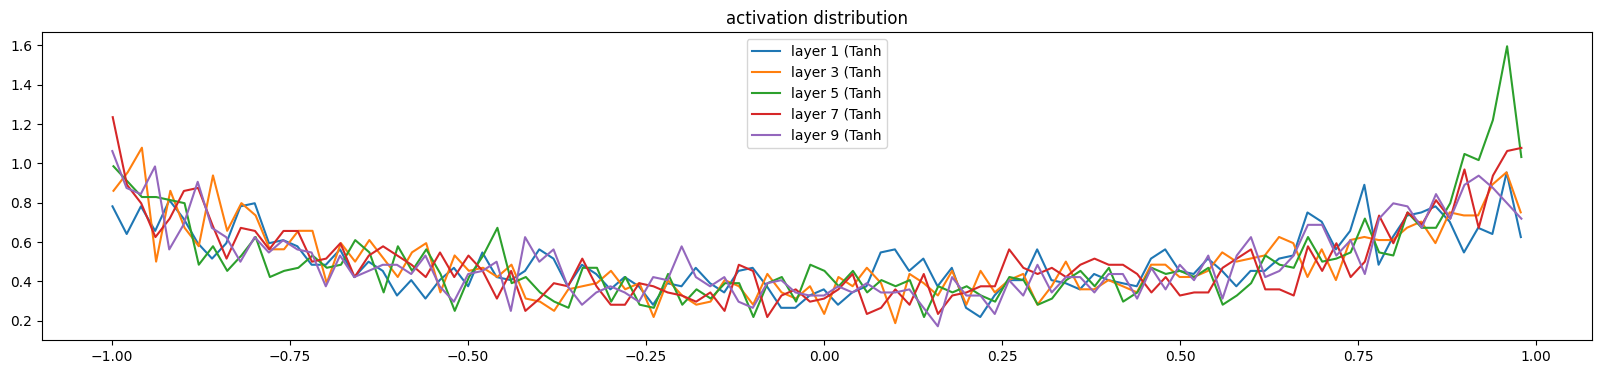

layer 1 (      Tanh): mean +0.000007, std 0.000420
layer 3 (      Tanh): mean -0.000005, std 0.000386
layer 5 (      Tanh): mean -0.000003, std 0.000365
layer 7 (      Tanh): mean -0.000002, std 0.000341
layer 9 (      Tanh): mean -0.000001, std 0.000310


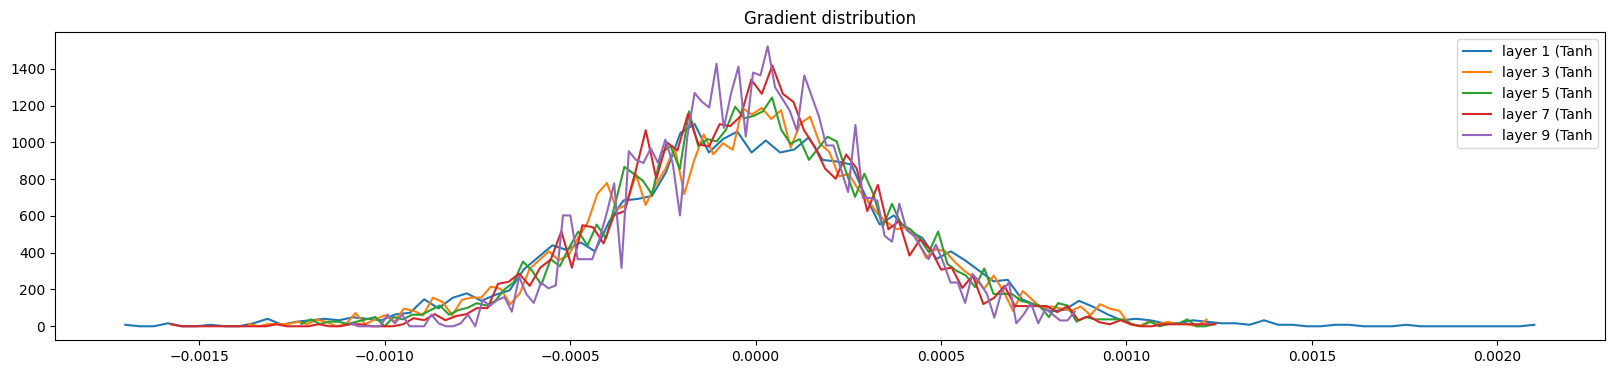

In [106]:
# Tanh activation

C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)

#### Experiment 2: Too-low gain (0.5)

With gain=0.5 (severely under-compensating for tanh's variance squashing), we expect the activation std to **shrink dramatically with each layer**. Each tanh reduces the variance, and with such a low gain the reduction compounds aggressively — deeper layers will have activations clustered tightly around 0, where tanh is approximately linear. The network effectively loses its nonlinearity in deeper layers.

**What to watch for in the gradient plot:** the gradient std should **shrink as it flows backward toward the input** (vanishing gradients). But the reason is subtle — it's not caused by tanh saturation (there is none!). It's caused by the **small weight matrices**. Between consecutive Tanh layers, the backward gradient passes through:

```
grad_prev = (grad_current × tanh_derivative) @ W^T
```

Two factors compete at each step:

1. **Tanh derivative** `(1 - tanh²(x))` — near 1.0 here, because activations are small and tanh is near-linear. This barely shrinks the gradient.
2. **Weight matrix** `W^T` — with gain=0.5, the weights are small. Multiplying by a small matrix **shrinks** the gradient significantly.

Since the tanh derivative ≈ 1 (no help) and the weights are small (shrinking), the net effect at each backward step is: **gradient shrinks**. This compounds across layers, so layer 1 (near input) ends up with the smallest gradient.


Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s, loss=3.2954]

layer 1 (      Tanh): mean -0.03, std 0.60, saturated: 2.84%
layer 3 (      Tanh): mean +0.01, std 0.27, saturated: 0.00%
layer 5 (      Tanh): mean +0.01, std 0.14, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.07, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.03, saturated: 0.00%


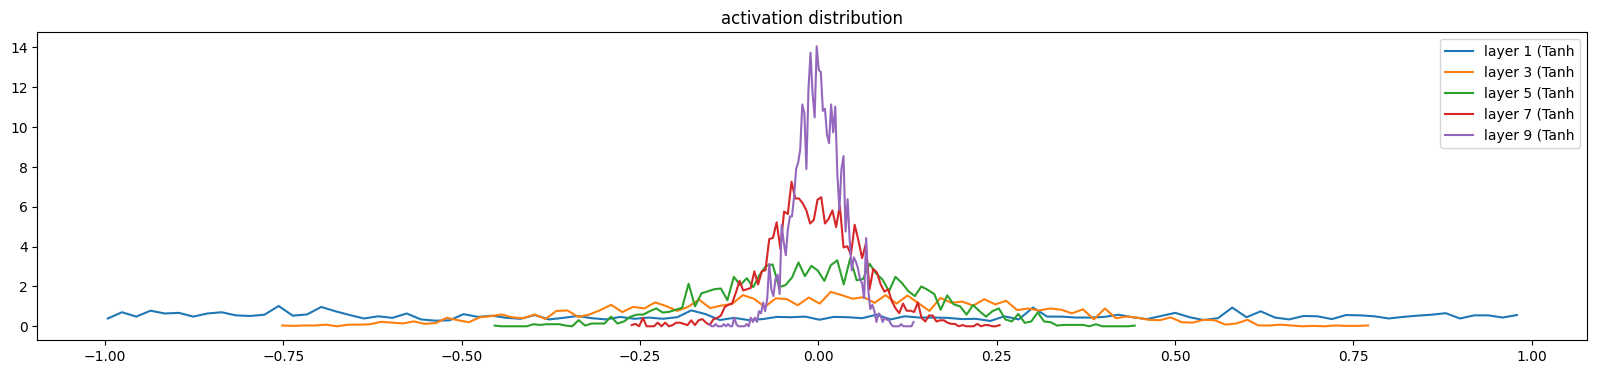

layer 1 (      Tanh): mean +0.000000, std 0.000019
layer 3 (      Tanh): mean -0.000000, std 0.000039
layer 5 (      Tanh): mean -0.000001, std 0.000077
layer 7 (      Tanh): mean -0.000002, std 0.000153
layer 9 (      Tanh): mean -0.000002, std 0.000313


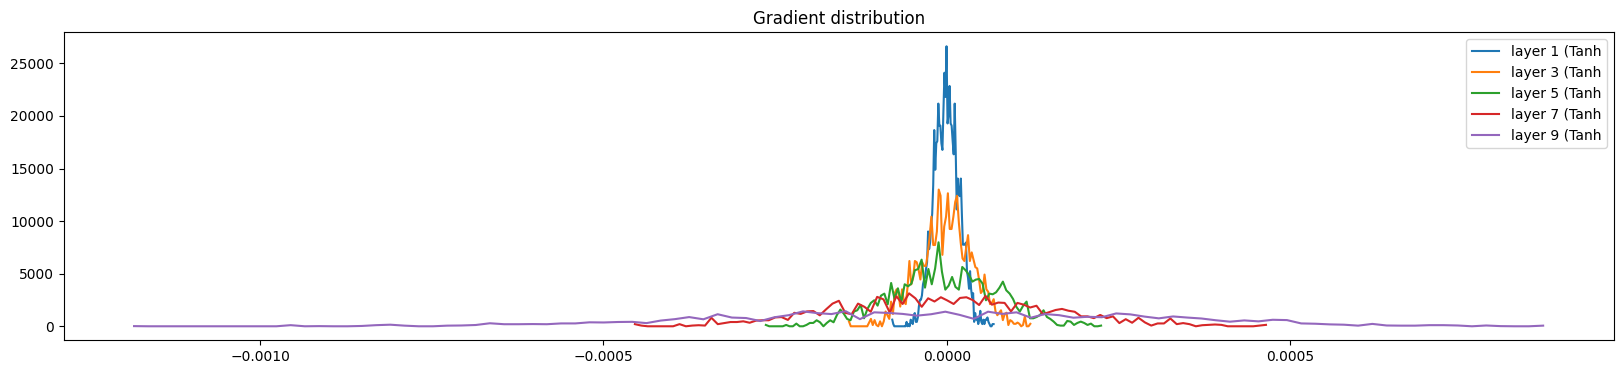

In [107]:
# what happens if we set the tanh gain to 1 instead of 5/3, i.e. something lower?
C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 0.5})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)

#### Experiment 3: Too-high gain (3.0)

With gain=3.0 (overcorrecting), we expect activations to **grow** with depth and saturate. The pre-activation values become so large that tanh squashes nearly everything to ±1, producing the U-shaped distribution (~40% of neurons saturated).

**What to watch for in the gradient plot:** counterintuitively, the gradient std should **grow as it flows backward toward the input** — the opposite of experiment 2! Despite tanh saturation killing some of the gradient, the **large weight matrices** more than compensate. The same backward step applies:

```
grad_prev = (grad_current × tanh_derivative) @ W^T
```

1. **Tanh derivative** `(1 - tanh²(x))` — significantly less than 1 here (saturation means many outputs near ±1, so `1 - 1² ≈ 0` for those neurons). This **shrinks** the gradient.
2. **Weight matrix** `W^T` — with gain=3.0, the weights are large. Multiplying by a large matrix **amplifies** the gradient.

The amplification from the large weights **wins** over the shrinkage from saturation, so the net effect at each backward step is: **gradient grows**. This compounds across layers, making layer 1 (near input) end up with the _largest_ gradient — the opposite direction from experiment 2.

This is a case of mildly **exploding** activation gradients, even though the activations themselves are saturated. The two problems (saturation + exploding backward signal) coexist because they're driven by different mechanisms.


Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s, loss=3.2855]

layer 1 (      Tanh): mean +0.02, std 0.63, saturated: 4.47%
layer 3 (      Tanh): mean -0.04, std 0.80, saturated: 28.09%
layer 5 (      Tanh): mean -0.02, std 0.84, saturated: 38.19%
layer 7 (      Tanh): mean +0.01, std 0.83, saturated: 39.09%
layer 9 (      Tanh): mean +0.01, std 0.83, saturated: 39.09%


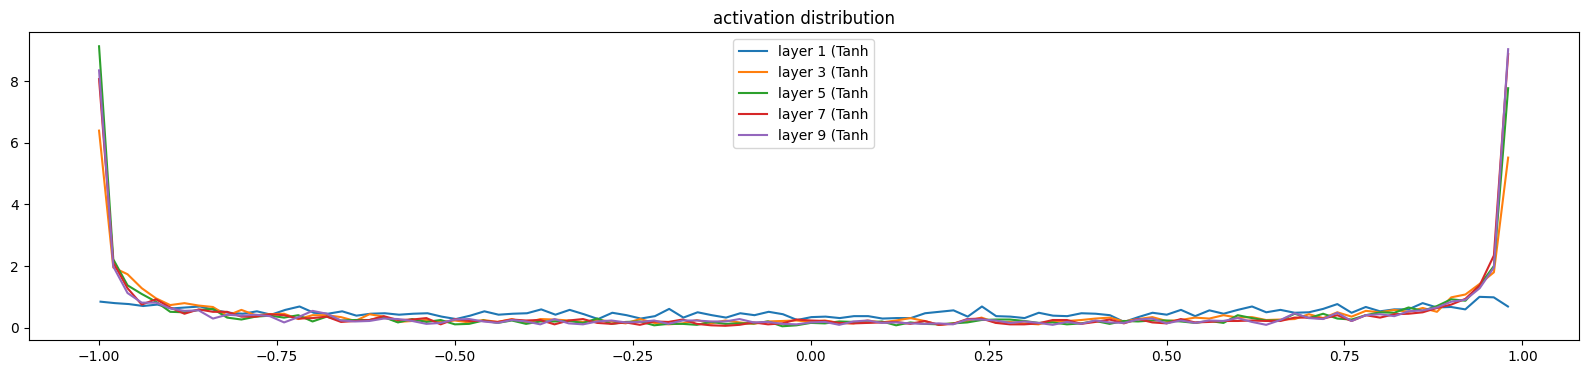

layer 1 (      Tanh): mean +0.000000, std 0.001290
layer 3 (      Tanh): mean -0.000008, std 0.000824
layer 5 (      Tanh): mean +0.000009, std 0.000578
layer 7 (      Tanh): mean -0.000001, std 0.000424
layer 9 (      Tanh): mean +0.000008, std 0.000306


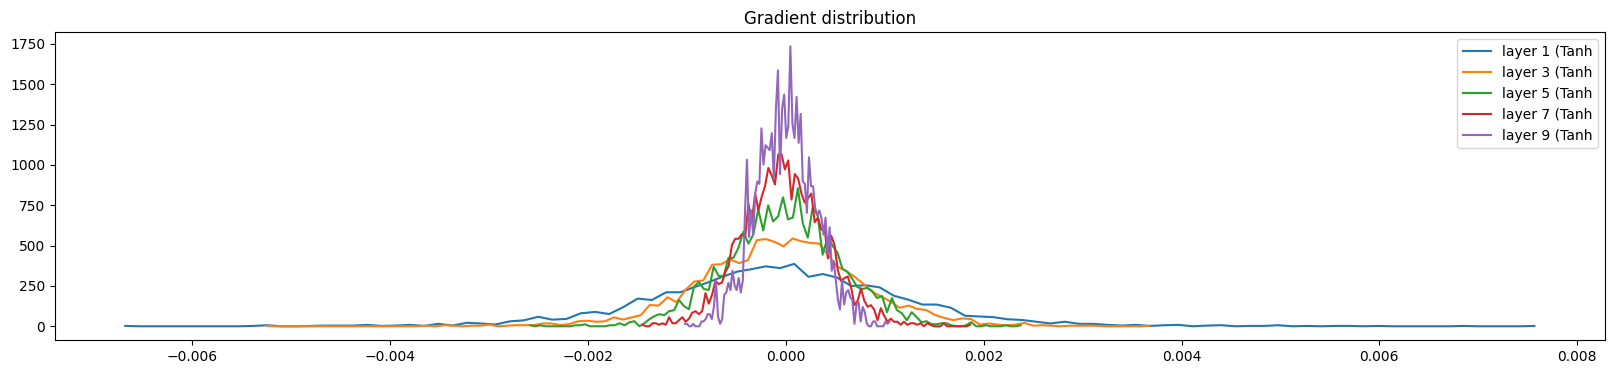

In [108]:
# what happens if we set the tanh gain to 10 instead 3 of 5/3, i.e. something higher?
C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 3.0})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)

### Observations: the effect of tanh gain on activation and gradient distributions

**Activations:**

We see that without batchnorm, we have to be very careful with our initialization. When we used the suggested `5/3` gain from the Kaiming He paper for tanh, we observe that our layers (regardless of depth) have a std of around `0.65`, with a reasonable number of saturated neurons and the activations follow a reasonable distribution.

When we `decrease` the gain from `5/3`, we see that the `std` keeps dropping as we go deeper (and we have no saturated neurons). This happens because `tanh` is a squashing fn, it takes its inputs and squashes them to be between ±1. Subsequent tanhs keep on squashing this further and further. This is undesirable because in this case, when tanh → 0, the tanh will simply start to act as a passthrough fn and not offer any learnings.

On the flip side, when we increase the gain, we see that the `std` keeps on increasing and we start having more and more saturated neurons. This is because too high of a gain forces the distribution of tanh to act towards its end regions.

**Gradients — and why the trends are reversed:**

The gradient distributions reveal something surprising: the std trends go in **opposite directions** between experiments 2 and 3.

| Experiment | Layer 9 (near output) | Layer 1 (near input) | Trend (backward)              |
| ---------- | --------------------- | -------------------- | ----------------------------- |
| Gain=0.5   | std ≈ 0.000294        | std ≈ 0.000016       | **shrinks** ~18× toward input |
| Gain=5/3   | std ≈ 0.000312        | std ≈ 0.000441       | roughly **stable**            |
| Gain=3.0   | std ≈ 0.000292        | std ≈ 0.001237       | **grows** ~4× toward input    |

This reversal happens because gradient magnitude at each backward step is controlled by **two competing factors**:

$$|\text{grad}\_{\text{prev}}| \approx |\text{grad}\_{\text{current}}| \times \underbrace{(1 - \tanh^2(x))}\_{\text{tanh derivative}} \times \underbrace{||W^T||}\_{\text{weight magnitude}}$$

- **Gain=0.5:** tanh derivative ≈ 1 (activations near 0, tanh is linear), but weights are small → `1.0 × small < 1` → gradient **shrinks** each step → vanishing toward input
- **Gain=5/3:** tanh derivative ≈ 0.58 and weights are tuned to exactly compensate → `0.58 × 1.67 ≈ 1` → gradient stays **stable**
- **Gain=3.0:** tanh derivative < 1 (saturation), but weights are large → `small × 3.0 > 1` → gradient **grows** each step → exploding toward input

The key insight: **the gain controls which factor dominates**. Low gain → small weights dominate → vanishing. High gain → large weights dominate → exploding (even with saturation). The "correct" gain of `5/3` is precisely the value where the two factors cancel out.

**The core takeaway:** without BatchNorm, any error in the gain factor **compounds across layers** in _both_ directions — the forward pass shows activations either collapsing or saturating, and the backward pass shows gradients either vanishing or exploding. The "correct" gain of `5/3` is the knife-edge where both signals are preserved — but this only works for tanh specifically, and only at initialization (as training proceeds, the weight distributions change). This fragility is precisely why BatchNorm was such an important innovation: it forces each layer's activations to have well-behaved statistics regardless of what the weights look like, which in turn keeps the gradients healthy too.


### Looking at weight gradient and update ratio plots

Now that we looked at activation and gradient of activation plots, lets also look and understand at what is happening with our actual parameters, i.e. the weights (ignoring biases and batchnorm params for now) of the network.

Recall from the [aside above](#Aside:-Why-plots-for-both-activation-gradient-and-weight-gradient?): the weight gradient `∂L/∂W = x^T @ (∂L/∂h)` depends on _both_ the forward-pass input and the backward-pass gradient. So even if the activation gradient plot looks healthy, the weight gradients can reveal problems that only show up when the two are combined. The **grad:data ratio** (`grad.std() / param.std()`) printed for each weight matrix tells us how aggressively each layer is being updated relative to its current values — ideally this should be in the same ballpark across all layers.


Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s, loss=3.3139]

layer 1 (      Tanh): mean -0.02, std 0.65, saturated: 5.09%
layer 3 (      Tanh): mean -0.02, std 0.65, saturated: 5.22%
layer 5 (      Tanh): mean +0.03, std 0.64, saturated: 4.47%
layer 7 (      Tanh): mean +0.03, std 0.64, saturated: 4.59%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 5.44%


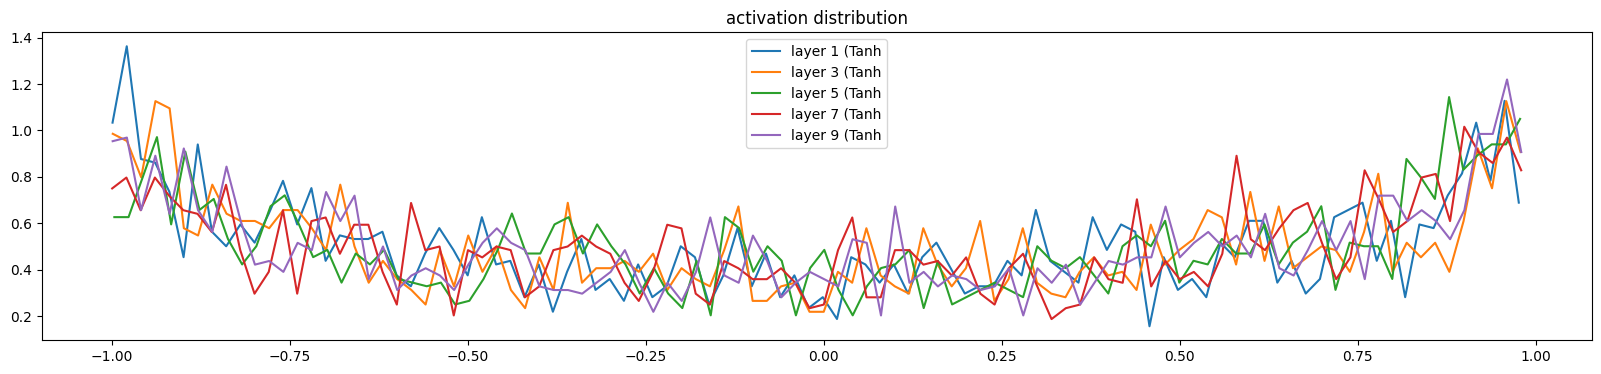

layer 1 (      Tanh): mean -0.000020, std 0.000466
layer 3 (      Tanh): mean +0.000012, std 0.000427
layer 5 (      Tanh): mean +0.000001, std 0.000382
layer 7 (      Tanh): mean -0.000005, std 0.000341
layer 9 (      Tanh): mean -0.000002, std 0.000299


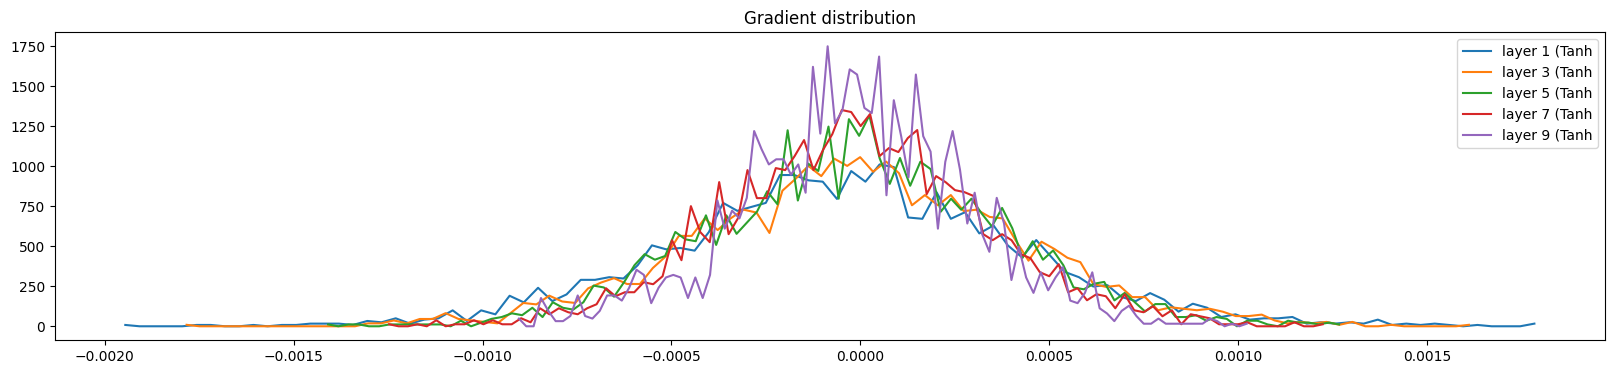

weight   (27, 10) | mean -0.000010 | std 1.050935e-03 | grad:data ratio 1.029349e-03
weight  (30, 100) | mean -0.000007 | std 1.989341e-03 | grad:data ratio 1.109792e-02
weight (100, 100) | mean -0.000000 | std 1.095507e-03 | grad:data ratio 6.529481e-03
weight (100, 100) | mean +0.000007 | std 1.049540e-03 | grad:data ratio 6.293380e-03
weight (100, 100) | mean +0.000004 | std 9.503764e-04 | grad:data ratio 5.725924e-03
weight (100, 100) | mean -0.000005 | std 7.678489e-04 | grad:data ratio 4.629563e-03
weight  (100, 27) | mean +0.000000 | std 2.406231e-02 | grad:data ratio 2.378889e+00


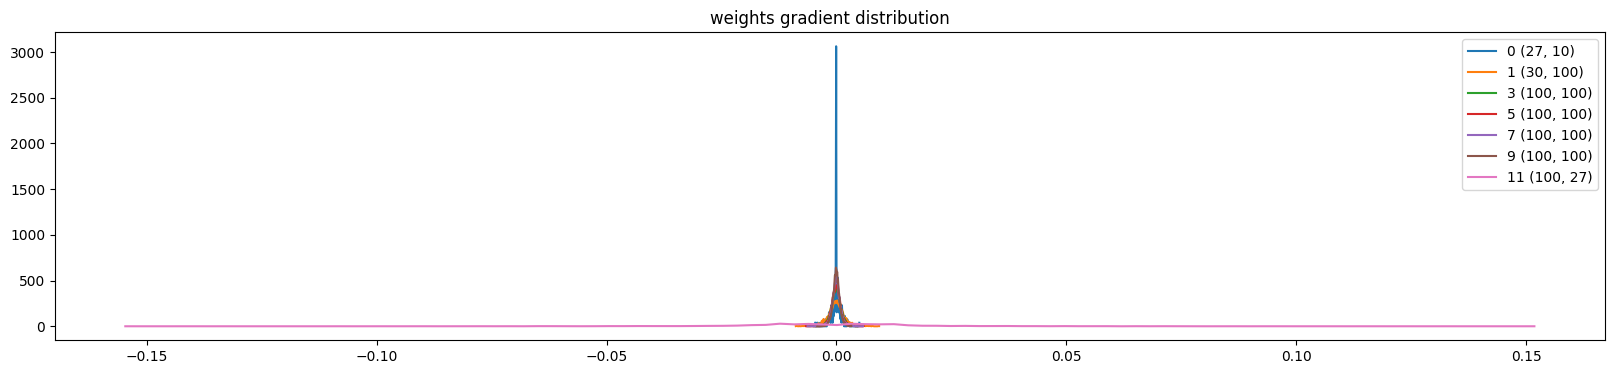

In [109]:
# Using the ideal gain

C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)
plot_weights_gradient_distribution(parameters)

We see a weird phenomenon here. While the weights of most layers are well behaved (with ballpark std of ~`1e-3`), the weights of the last layer are taking on much larger values (with std ~`1e-2`). This means that the output layer will be training 10x faster than all the other layers.

The reason for that is we manually shrunk the output layer at initialization (by using a gain of `0.1`) in order to make the predictions uniform and less confident.

Look at the grad:data ratio to see this clearly: the hidden layers have ratios around `5e-3` to `1e-2`, while the output layer `(100, 27)` has a ratio of **~2.4** — that's roughly **200-400× larger** than the other layers. This happens because the output weights are tiny (we scaled them by 0.1), so even a normal-sized gradient represents a huge _relative_ change. In effect, the output layer is learning orders of magnitude faster than the rest of the network at initialization. This imbalance resolves itself as the output weights grow during training, but it means the first few hundred steps are dominated by the output layer adjusting while the hidden layers barely move.


#### What happens after training for longer?

The 1-step snapshot above shows the network at initialization. But initialization is just the starting point — what matters is whether the network _stays_ healthy as training proceeds. Training changes the weights, which changes the activation distributions, which changes the gradients. With no BatchNorm to enforce well-behaved statistics, any drift in the weight distributions can compound and push the network into saturation over time. Let's train for 1,000 steps and check.


Total number of parameters in model: 46497


Training: 100%|██████████| 1000/1000 [00:04<00:00, 244.07it/s, loss=2.1918]


layer 1 (      Tanh): mean +0.01, std 0.63, saturated: 3.38%
layer 3 (      Tanh): mean -0.02, std 0.69, saturated: 7.53%
layer 5 (      Tanh): mean +0.02, std 0.72, saturated: 10.38%
layer 7 (      Tanh): mean -0.00, std 0.73, saturated: 12.03%
layer 9 (      Tanh): mean -0.04, std 0.71, saturated: 10.84%


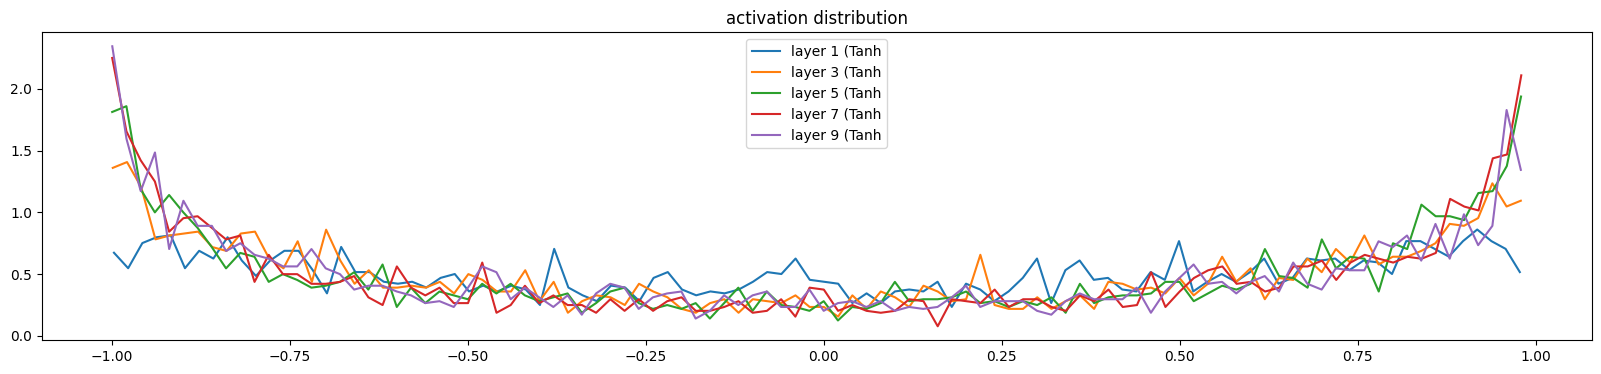

layer 1 (      Tanh): mean -0.000070, std 0.003932
layer 3 (      Tanh): mean +0.000072, std 0.003563
layer 5 (      Tanh): mean -0.000143, std 0.003205
layer 7 (      Tanh): mean -0.000079, std 0.002991
layer 9 (      Tanh): mean -0.000029, std 0.002535


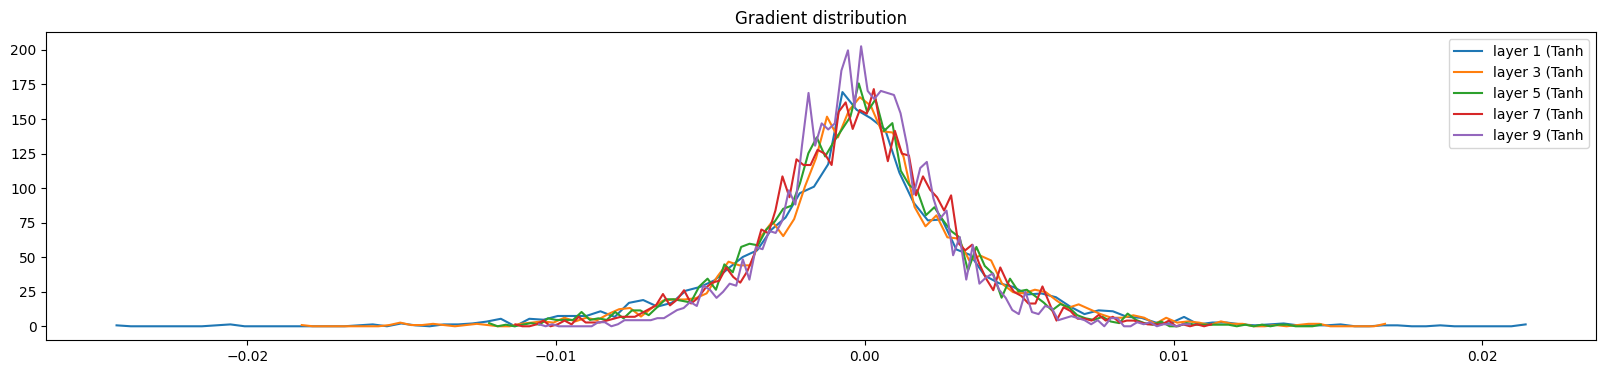

weight   (27, 10) | mean +0.001503 | std 1.121187e-02 | grad:data ratio 1.183380e-02
weight  (30, 100) | mean +0.000343 | std 1.488988e-02 | grad:data ratio 8.033413e-02
weight (100, 100) | mean +0.000002 | std 7.801283e-03 | grad:data ratio 4.653814e-02
weight (100, 100) | mean -0.000024 | std 7.563109e-03 | grad:data ratio 4.489851e-02
weight (100, 100) | mean -0.000019 | std 7.169088e-03 | grad:data ratio 4.276543e-02
weight (100, 100) | mean -0.000062 | std 5.983968e-03 | grad:data ratio 3.618738e-02
weight  (100, 27) | mean +0.000000 | std 2.332438e-02 | grad:data ratio 3.485744e-01


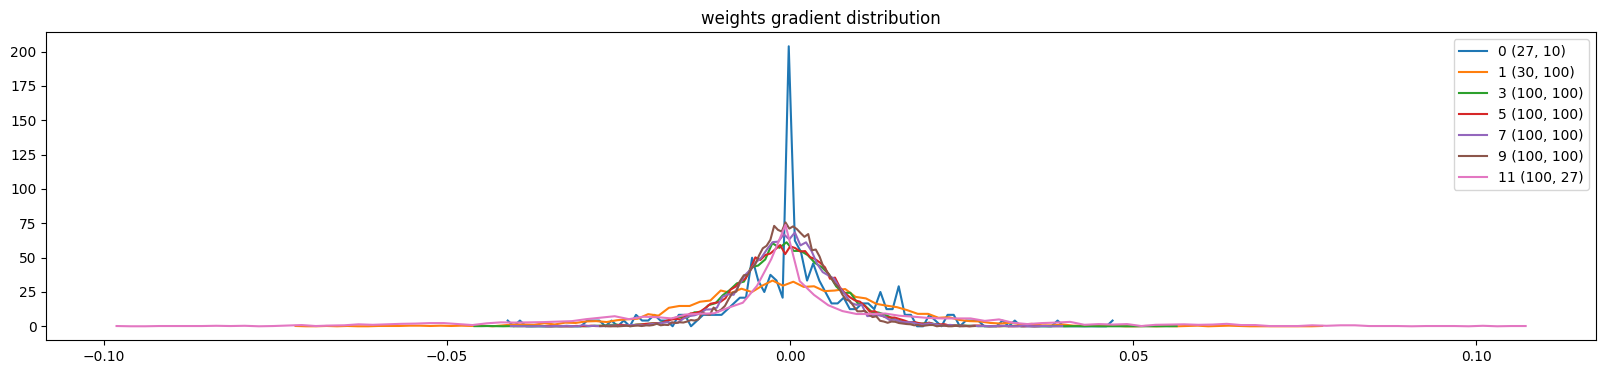

In [138]:
# Using the ideal gain

C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1000)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)
plot_weights_gradient_distribution(parameters)

#### Observations after 1K steps

We can see that as we train for a few thousand steps, we notice that -

1. **Activations are becoming more saturated** — the std has grown from ~0.65 to ~0.70, and saturation has jumped from ~5% to 10% across layers. This is exactly the drift we warned about: even though we started with the "correct" gain of 5/3, training has pushed the weights away from their initial values, and without BatchNorm there's nothing to pull the activation distributions back into a healthy range.

2. **The activation gradients are still reasonably well behaved** — the std values across layers are in the same ballpark (~0.0027), meaning the backward signal hasn't collapsed yet. This is a reminder that gradient health and activation health are separate concerns — activations can start saturating before the gradients show obvious problems.

3. **The output layer's grad:data ratio is shrinking but still dominant** — it dropped from ~2.4 to ~0.3 as the output weights grew during training, but it's still significantly larger than the hidden layers (~0.01-0.06). The hidden layers' ratios have also grown from ~5e-3 to ~3e-2, meaning they're now learning more aggressively — which is partly _why_ the activations are drifting toward saturation.

This demonstrates the fundamental fragility of training without BatchNorm: even with perfect initialization, the network gradually drifts out of its healthy operating range as training proceeds. BatchNorm prevents this by re-normalizing activations at every forward pass, regardless of what the weights look like.


#### Update-to-data ratio in practice

Another very important plot to look at is to see the ratio of the parameter update to its value. This is the fourth and final diagnostic from Section 2 — and arguably the most actionable one, because it directly tells you whether your **learning rate** is well-calibrated for each layer.


param 0 | mean (last 500 steps) -2.977778
param 1 | mean (last 500 steps) -2.166640
param 3 | mean (last 500 steps) -2.409603
param 5 | mean (last 500 steps) -2.442696
param 7 | mean (last 500 steps) -2.479651
param 9 | mean (last 500 steps) -2.544800
param 11 | mean (last 500 steps) -1.434802


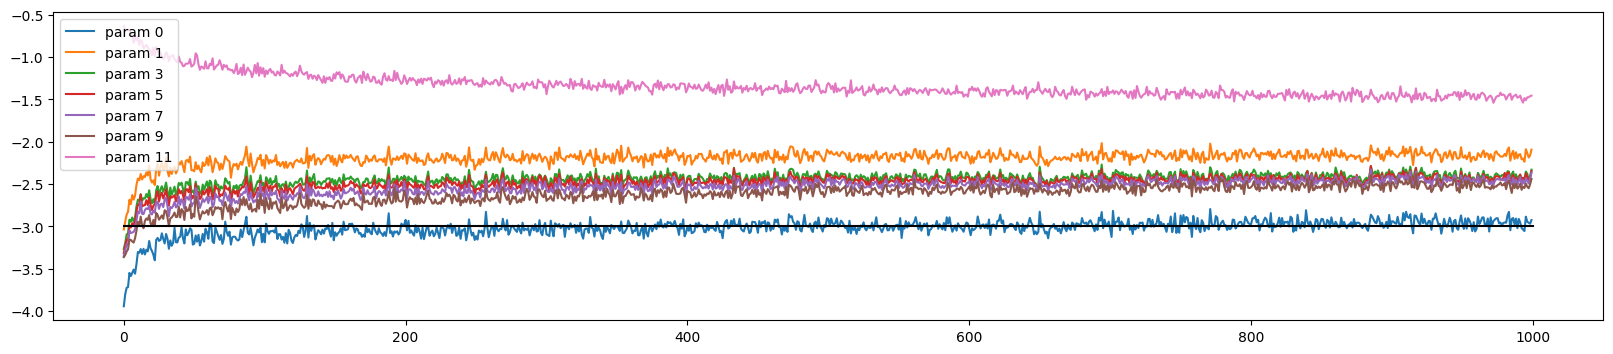

In [166]:
plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio)

Okay, now what is this plot telling us — it shows the magnitude of the ratio of the update to a parameter to its value. We ideally want this to be near `-3` in the plot (which is log10 based), i.e. we want our updates to the parameters to be `1000` times smaller than their value. Secondly, we want all layers to roughly change at the same rate/magnitude which is what is happening here.

This plot can also help us understand the impact of our lr and how we can tweak it. In the case above, we already had an ideal learning rate from our previous notebook. But what if we had started too high or too low? The update-to-data ratio plot makes this immediately obvious — if all curves are below the -3 line, the learning rate is too low; if they're above, it's too high.

Notice that param 11 (the output layer `(100, 27)`) sits well above the -3 line at ~-1.4, confirming what we saw in the weight gradient plot: the output layer is still learning much faster than the hidden layers due to the 0.1 initialization scaling.


#### LR too low (0.001)

With lr=0.001 (100× smaller than our ideal of 0.1), we expect all the update-to-data ratio curves to fall **well below the -3 line**. The network is barely changing its parameters — each update is a tiny fraction of the parameter values. The activation and gradient plots should still look healthy (the network is well-initialized), but learning will be painfully slow.


Total number of parameters in model: 46497


Training: 100%|██████████| 1000/1000 [00:03<00:00, 311.81it/s, loss=2.9714]


layer 1 (      Tanh): mean +0.02, std 0.64, saturated: 5.31%
layer 3 (      Tanh): mean -0.01, std 0.64, saturated: 4.84%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 5.16%
layer 7 (      Tanh): mean +0.05, std 0.66, saturated: 5.12%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.44%


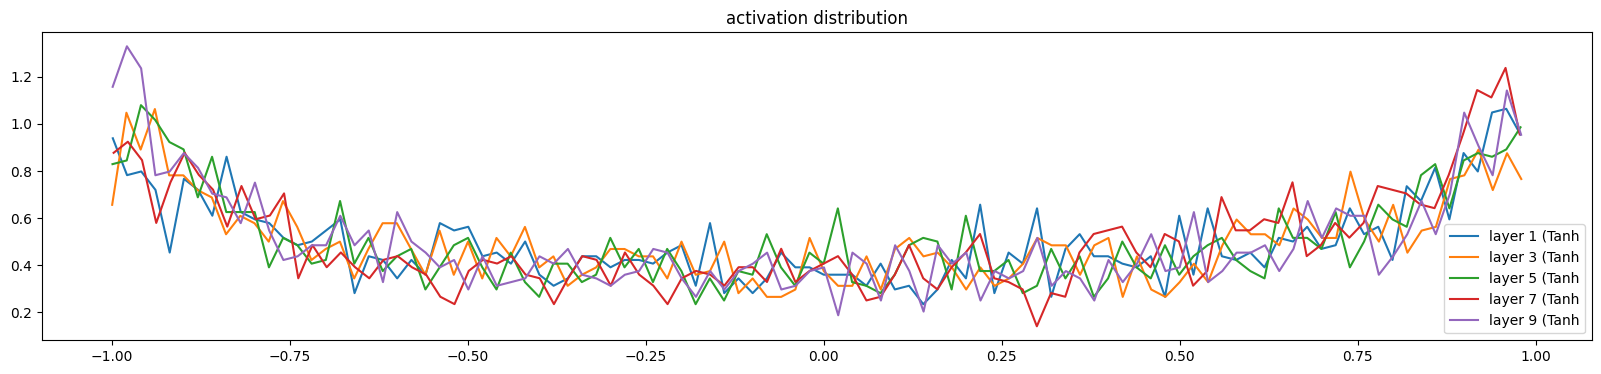

layer 1 (      Tanh): mean +0.000005, std 0.000969
layer 3 (      Tanh): mean -0.000012, std 0.000798
layer 5 (      Tanh): mean -0.000003, std 0.000690
layer 7 (      Tanh): mean -0.000022, std 0.000567
layer 9 (      Tanh): mean +0.000016, std 0.000466


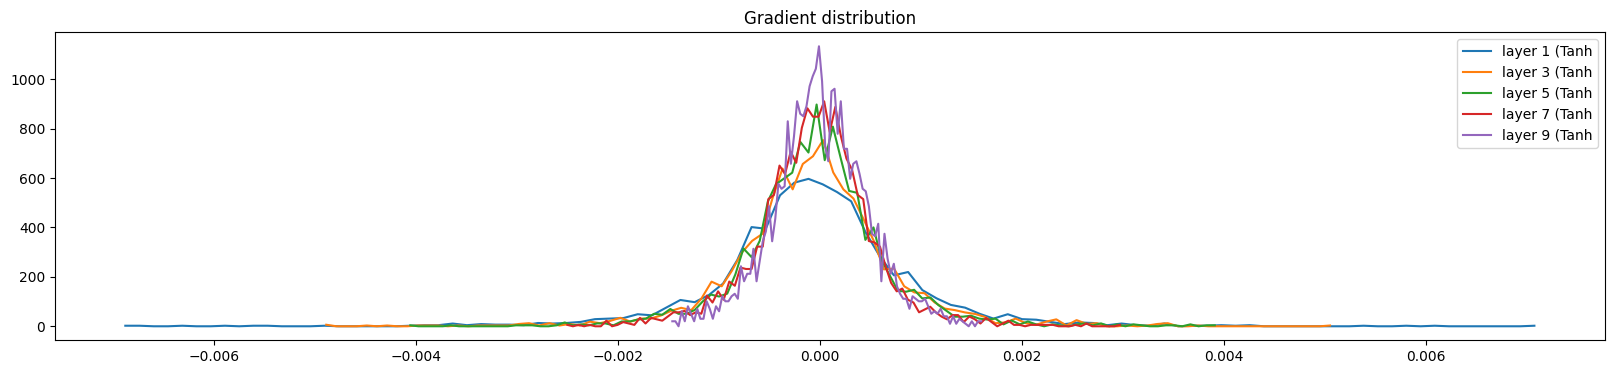

weight   (27, 10) | mean -0.000398 | std 2.721324e-03 | grad:data ratio 2.673386e-03
weight  (30, 100) | mean -0.000049 | std 3.823826e-03 | grad:data ratio 2.103224e-02
weight (100, 100) | mean -0.000014 | std 2.045979e-03 | grad:data ratio 1.218081e-02
weight (100, 100) | mean -0.000033 | std 1.804974e-03 | grad:data ratio 1.081645e-02
weight (100, 100) | mean -0.000007 | std 1.459977e-03 | grad:data ratio 8.783100e-03
weight (100, 100) | mean +0.000011 | std 1.224835e-03 | grad:data ratio 7.317453e-03
weight  (100, 27) | mean +0.000000 | std 2.273352e-02 | grad:data ratio 1.810433e+00


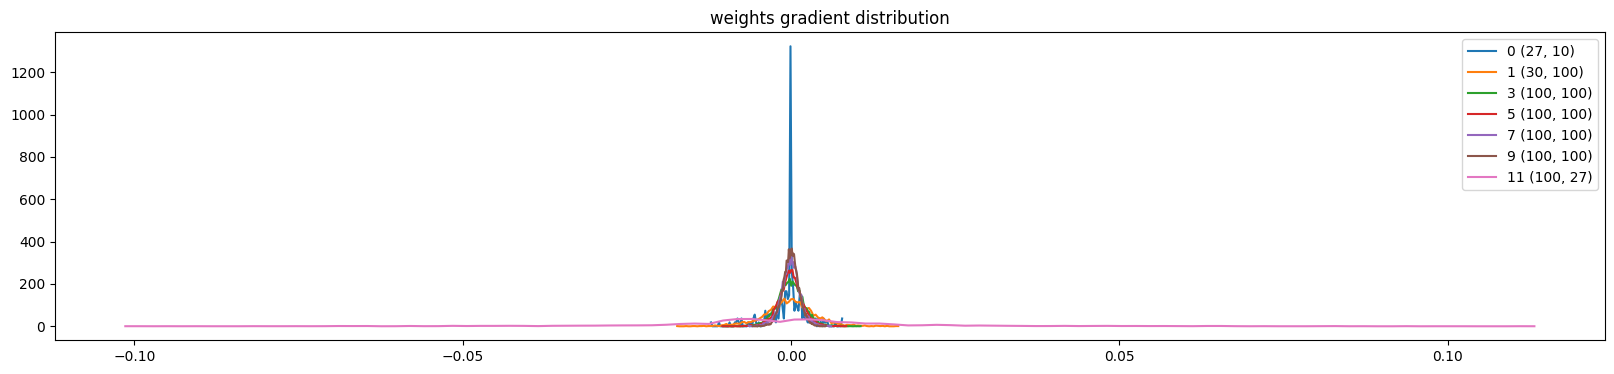

param 0 | mean (last 500 steps) -5.609683
param 1 | mean (last 500 steps) -4.668279
param 3 | mean (last 500 steps) -4.946841
param 5 | mean (last 500 steps) -5.024505
param 7 | mean (last 500 steps) -5.098269
param 9 | mean (last 500 steps) -5.197587
param 11 | mean (last 500 steps) -2.706906


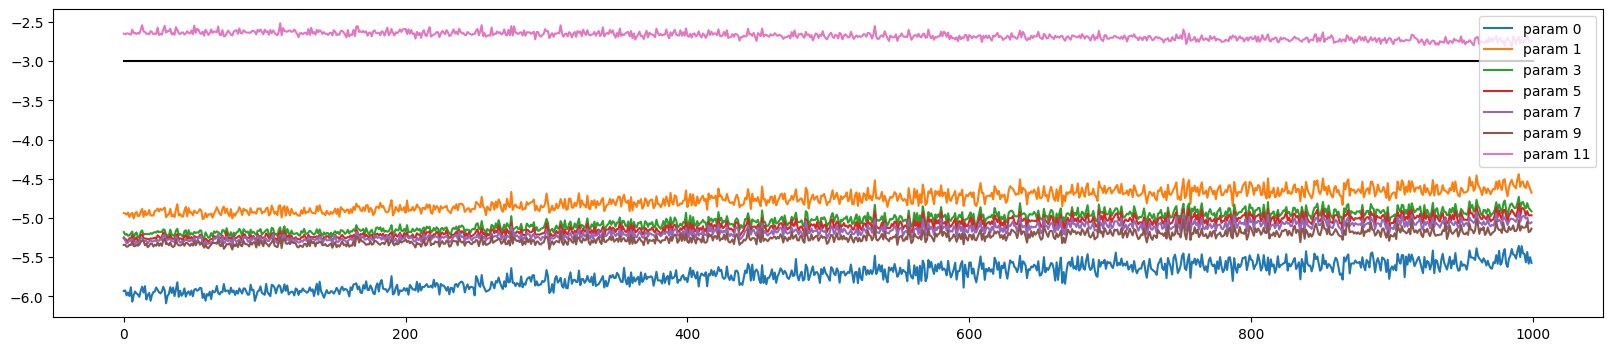

In [173]:
# LR too low

C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1000, lr=0.001)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)
plot_weights_gradient_distribution(parameters)
plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio)

When our lr is too low, we can see that most layers' curves for `plot_weights_update_to_data_ratio_distribution` fall below the `k=-3` line (around -5), meaning that we can afford to train much faster. The activations and gradients still look healthy — this is the signature of a too-low learning rate: **nothing is broken, it's just slow**. The model will eventually converge, but it will take 100× longer than necessary.

The update-to-data ratio plot makes this diagnosis instant — without it, you'd just see a slowly-decreasing loss curve and wonder whether the model is stuck or just needs more time.


#### LR too high (1.0)

With lr=1.0 (10× larger than our ideal of 0.1), we expect the update-to-data ratio curves to sit **well above the -3 line**. But unlike the too-low case, a too-high learning rate is actively destructive — the large parameter updates can push activations into saturation, destabilize the gradient flow, and cause the loss to oscillate or diverge. We should see problems in _all four_ diagnostic plots, not just the update ratio.


Total number of parameters in model: 46497


Training: 100%|██████████| 1000/1000 [00:03<00:00, 300.10it/s, loss=6.2585]


layer 1 (      Tanh): mean -0.01, std 0.99, saturated: 97.62%
layer 3 (      Tanh): mean -0.02, std 0.98, saturated: 92.53%
layer 5 (      Tanh): mean +0.00, std 0.98, saturated: 90.06%
layer 7 (      Tanh): mean +0.05, std 0.97, saturated: 89.38%
layer 9 (      Tanh): mean +0.12, std 0.98, saturated: 93.03%


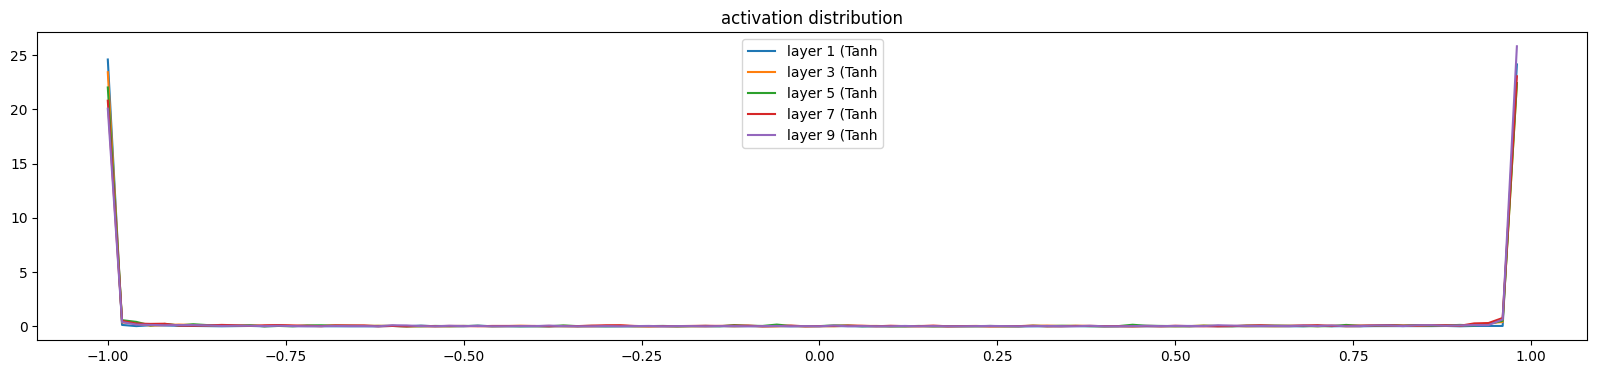

layer 1 (      Tanh): mean +0.000108, std 0.010595
layer 3 (      Tanh): mean -0.000118, std 0.012063
layer 5 (      Tanh): mean -0.000065, std 0.008399
layer 7 (      Tanh): mean +0.000013, std 0.006617
layer 9 (      Tanh): mean +0.000010, std 0.008771


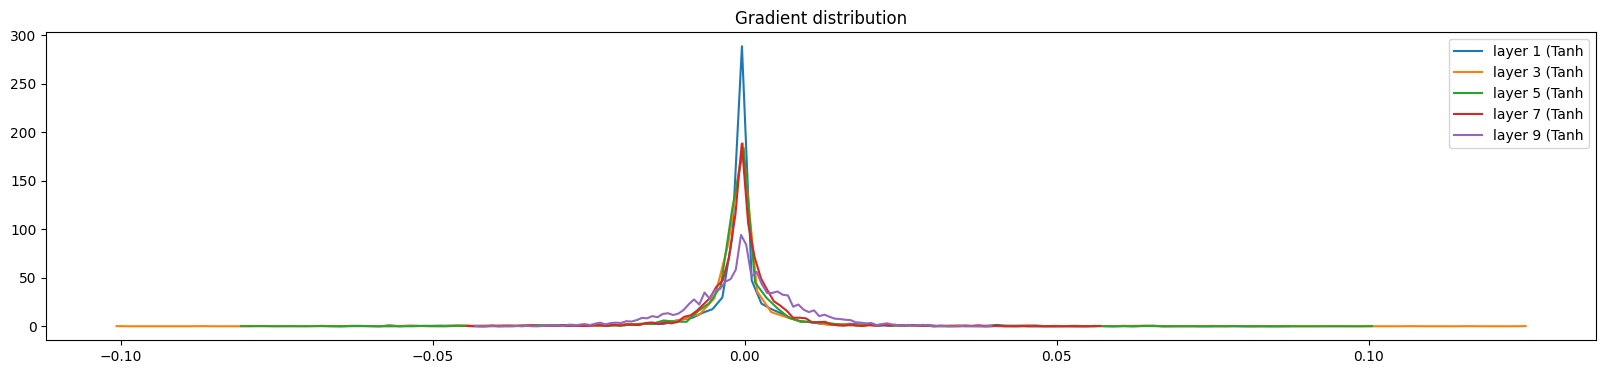

weight   (27, 10) | mean +0.000577 | std 1.838780e-02 | grad:data ratio 6.423581e-03
weight  (30, 100) | mean +0.000568 | std 1.689740e-02 | grad:data ratio 1.186704e-02
weight (100, 100) | mean -0.000048 | std 9.426963e-03 | grad:data ratio 1.724617e-02
weight (100, 100) | mean +0.000055 | std 1.224431e-02 | grad:data ratio 2.882038e-02
weight (100, 100) | mean +0.000089 | std 8.284290e-03 | grad:data ratio 2.102678e-02
weight (100, 100) | mean -0.000100 | std 8.942102e-03 | grad:data ratio 1.930407e-02
weight  (100, 27) | mean -0.000000 | std 6.191743e-02 | grad:data ratio 2.994240e-01


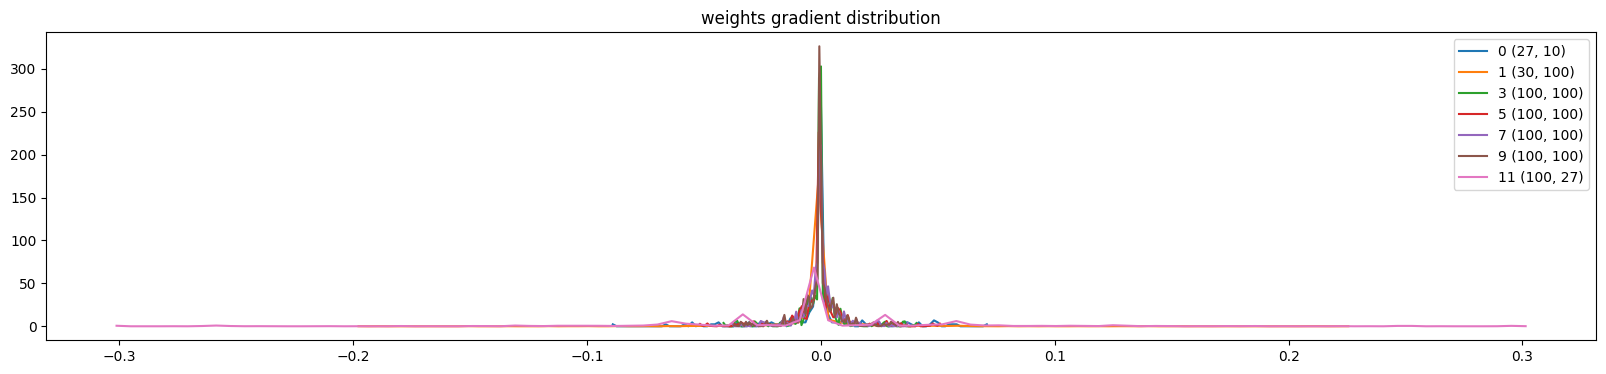

param 0 | mean (last 500 steps) -1.913532
param 1 | mean (last 500 steps) -1.757885
param 3 | mean (last 500 steps) -1.685029
param 5 | mean (last 500 steps) -1.654793
param 7 | mean (last 500 steps) -1.664130
param 9 | mean (last 500 steps) -1.693603
param 11 | mean (last 500 steps) -0.547413


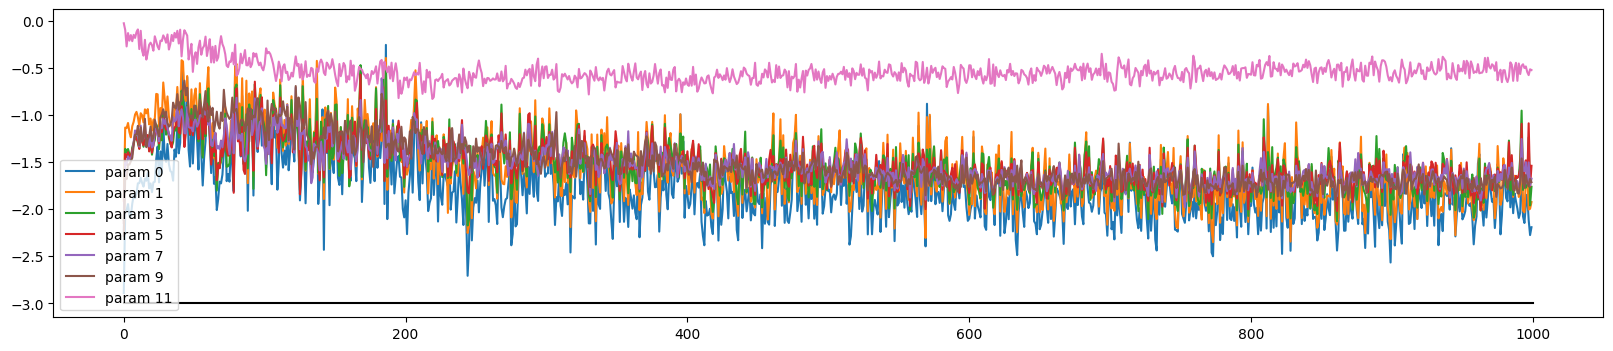

In [176]:
# LR too high

C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1000, lr=1)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)
plot_weights_gradient_distribution(parameters)
plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio)

Conversely, when our LR is too high, we can see that the curves with the ratio of parameter update to data are all above the `k=-3` line.

**What's happening:** With lr=1.0, each gradient step overwrites a large fraction of the parameter's current value. The ratio sits around `10^{-1.5}` to `10^{-1}` — meaning each update changes the weights by **3-10%** of their magnitude per step. At this rate, the optimizer is making huge jumps in parameter space, likely overshooting minima rather than converging toward them. The loss will bounce around erratically or diverge entirely.

**The key contrast:** With lr=0.001, ratios were around `10^{-4.5}` (barely moving). With lr=0.1, ratios sat near `10^{-3}` (the sweet spot). With lr=1.0, ratios are at `10^{-1.5}` to `10^{-1}` (destructively large). The update-to-data ratio gives us a direct, quantitative way to see this — no guessing from the loss curve needed.


#### Bringing it all together

Now lets see how we can use all these plots together to diagnose our trainig. Lets assume that we didnt do any scaling, like suggested by Kaiming He. Lets use our 4 diagnostic plots to check if we would have caught this issue.

**What `ignore_scaling=True` does:** In our `Linear` layer, the `ignore_scaling` flag sets the initialization factor to `1.0` instead of `√fan_in`. This means weights are drawn from `N(0, 1)` instead of `N(0, 1/√fan_in)`. Looking at `setup_model`, this flag is passed to both the **input layer** and all **hidden layers** — so every Linear layer in the network loses its Kaiming scaling. (The output layer doesn't receive the flag, but it still has `output_gain=0.1` applied.)

The effect is dramatic for two reasons:

- **Input layer** (fan_in=30): weights are `√30 ≈ 5.5×` too large
- **Hidden layers** (fan_in=100): weights are `√100 = 10×` too large, and then further multiplied by `tanh_gain=5/3`, making them `~16.7×` too large

With weights this oversized at every layer, the pre-activations entering each Tanh are far too wide, causing massive saturation throughout the entire network. This is exactly the scenario Kaiming He initialization was designed to prevent.


Total number of parameters in model: 46497


Training: 100%|██████████| 1000/1000 [00:03<00:00, 307.30it/s, loss=3.1202]


layer 1 (      Tanh): mean -0.08, std 0.98, saturated: 94.28%
layer 3 (      Tanh): mean +0.06, std 0.98, saturated: 91.38%
layer 5 (      Tanh): mean +0.02, std 0.97, saturated: 89.12%
layer 7 (      Tanh): mean +0.02, std 0.97, saturated: 88.56%
layer 9 (      Tanh): mean +0.03, std 0.97, saturated: 90.25%


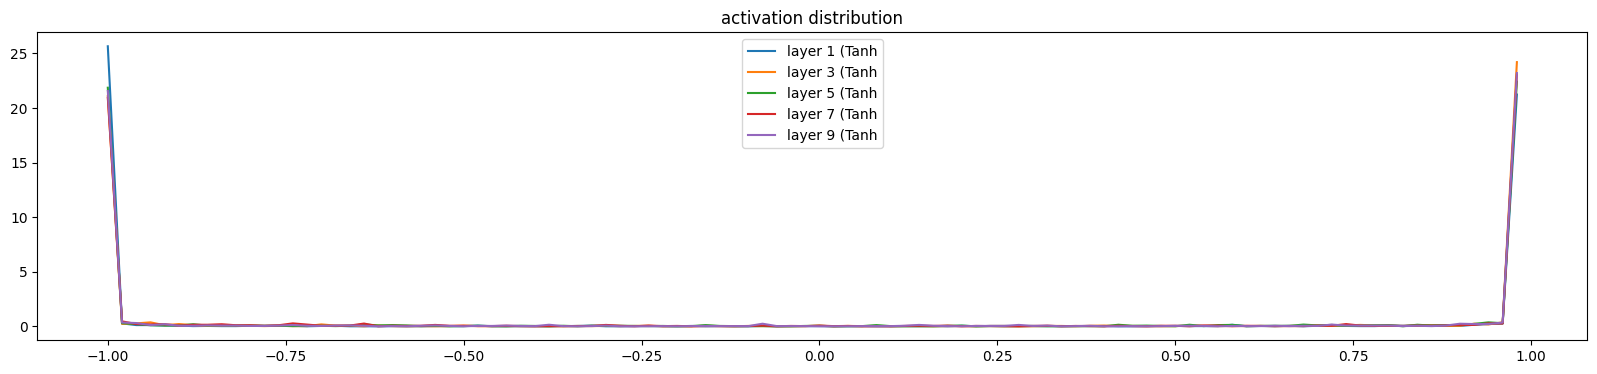

layer 1 (      Tanh): mean +0.002449, std 0.096332
layer 3 (      Tanh): mean +0.000630, std 0.050863
layer 5 (      Tanh): mean +0.000141, std 0.015757
layer 7 (      Tanh): mean -0.000058, std 0.005123
layer 9 (      Tanh): mean -0.000009, std 0.001657


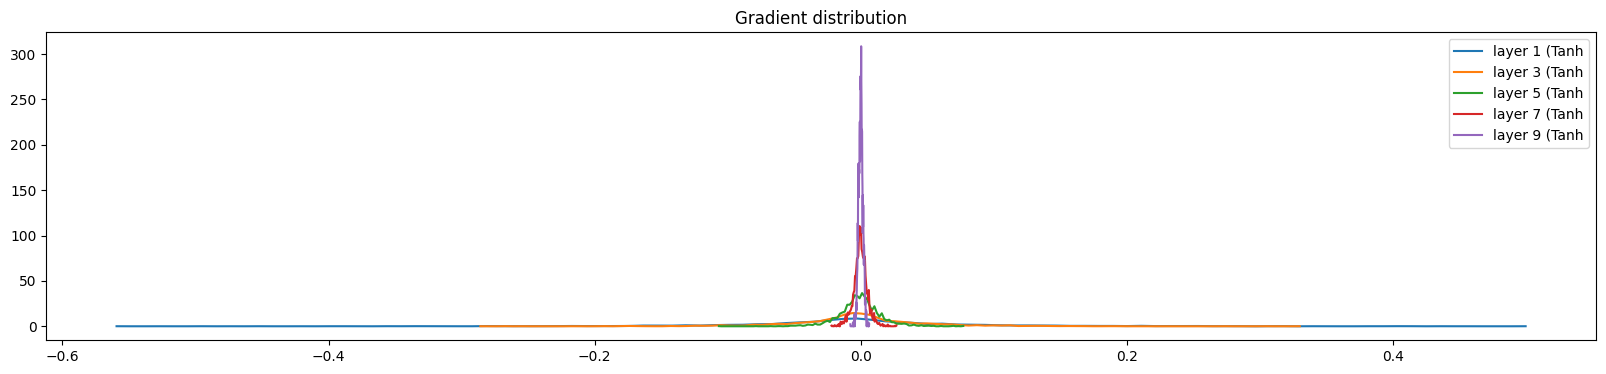

weight   (27, 10) | mean -0.003394 | std 2.675466e-01 | grad:data ratio 1.498066e-01
weight  (30, 100) | mean -0.000778 | std 1.513532e-01 | grad:data ratio 1.240676e-01
weight (100, 100) | mean -0.000437 | std 3.552835e-02 | grad:data ratio 2.138248e-02
weight (100, 100) | mean -0.000151 | std 1.416006e-02 | grad:data ratio 8.544647e-03
weight (100, 100) | mean +0.000021 | std 4.996009e-03 | grad:data ratio 2.990977e-03
weight (100, 100) | mean +0.000000 | std 1.598874e-03 | grad:data ratio 9.466262e-04
weight  (100, 27) | mean +0.000000 | std 3.125082e-02 | grad:data ratio 6.056989e-01


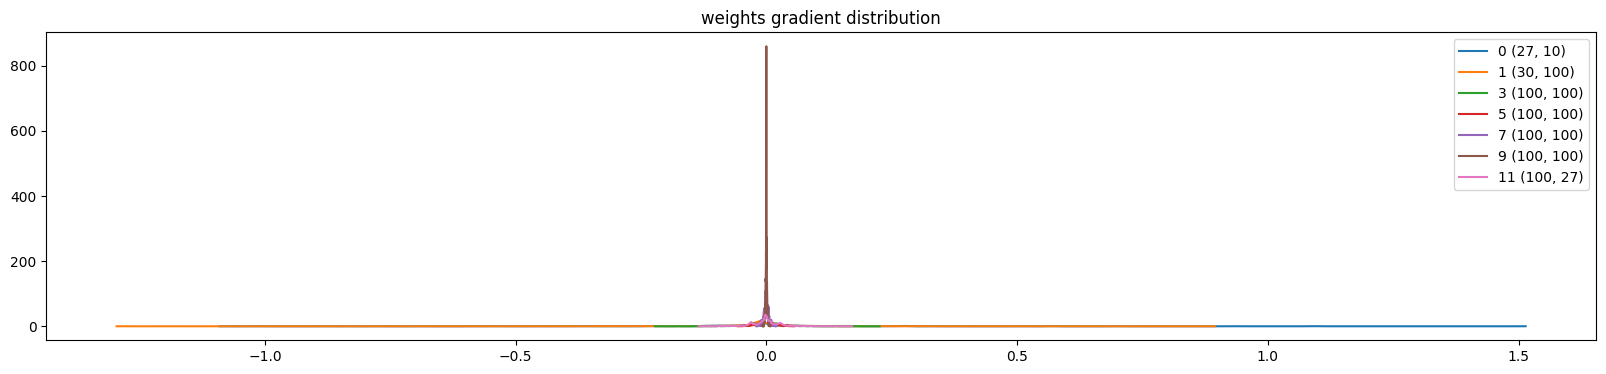

param 0 | mean (last 500 steps) -1.527671
param 1 | mean (last 500 steps) -1.738633
param 3 | mean (last 500 steps) -2.640940
param 5 | mean (last 500 steps) -3.078071
param 7 | mean (last 500 steps) -3.552461
param 9 | mean (last 500 steps) -4.034208
param 11 | mean (last 500 steps) -1.129818


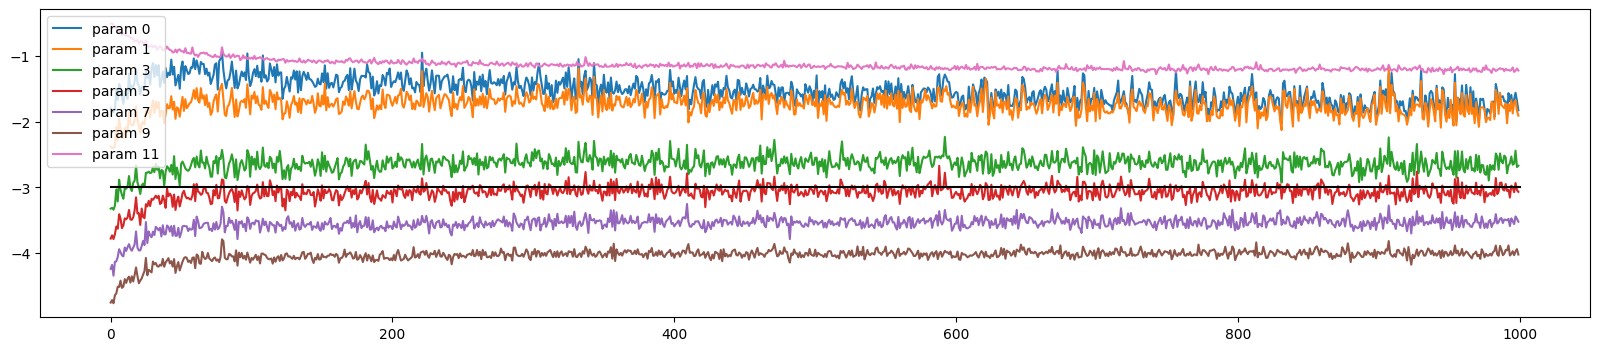

In [194]:
C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 5./3, "ignore_scaling": True})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1000)

plot_activation_distribution(layers)
plot_gradient_distribution(layers)
plot_weights_gradient_distribution(parameters)
plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio, n_steps_mean=0)

We can see that when we have a miscalibrated neural network, our diagnostic tools help us indentify that.

**What the diagnostics reveal:**

1. **Activation distribution:** Every Tanh layer is massively saturated — **88–94%** of neurons are pinned at ±1 (vs 3–12% in the well-calibrated model). This is the textbook consequence of oversized weights: the pre-activations are so large that tanh squashes almost everything to its extremes. The network has almost no neurons operating in tanh's useful linear region.

2. **Gradient distribution:** The gradients show clear **exploding** as we move from the output toward the input. The std _grows_ across 5 layers: layer 9 (closest to output) has std `0.0017`, layer 7 has `0.005`, layer 5 has `0.016`, layer 3 has `0.051`, layer 1 (closest to input) has `0.096` — a ~58× amplification. This is the same competing-factors dynamic we saw in Experiment 3: even though each saturated Tanh multiplies by a small `(1 - tanh²(x))`, the oversized weight matrices `||W^T||` more than compensate, amplifying the gradient at each backward step. Compare to the well-calibrated model where gradient stds are roughly uniform (~0.0025–0.004).

3. **Weight gradient distribution:** The grad:data ratios confirm the cascade. The deepest hidden layer (4th `(100,100)`, closest to output) has a ratio of just `0.0009` while the input layer `(30,100)` has `0.124` — a **130× spread**. The output layer `(100,27)` is the most extreme at `0.606`. In the well-calibrated model, hidden layers cluster between `0.036–0.080`. Because gradients explode toward the input, the input-side layers receive disproportionately large weight updates while the deeper hidden layers (closer to output) are effectively frozen.

4. **Update-to-data ratio:** This quantifies the damage over training. The output layer (param 11) has a mean log ratio of `-1.13` — meaning each step changes the weights by ~7.4% of their magnitude, wildly above the `10^{-3}` target. The deepest hidden layer (param 9) sits at `-4.03`, meaning updates are just 0.009% of weight magnitude — essentially frozen. The spread from `-1.13` to `-4.03` (a factor of ~800×) vs the well-calibrated model where all layers should cluster near `-3` makes the problem unmistakable.

**The takeaway:** Each diagnostic catches a different facet of the same underlying problem:

| Diagnostic                   | What it reveals                | Signal                               |
| ---------------------------- | ------------------------------ | ------------------------------------ |
| Activation distribution      | 88–94% saturation everywhere   | Neurons are dead                     |
| Gradient distribution        | 58× amplification toward input | Gradients are exploding              |
| Weight gradient distribution | 130× grad:data spread          | Learning is lopsided                 |
| Update-to-data ratio         | 800× spread (-1.1 to -4.0)     | Some layers frozen, others thrashing |

Together they tell a coherent story: oversized weights → universal tanh saturation → exploding gradients toward input → wildly uneven parameter updates. The loss (3.12 vs 2.19 for calibrated) does hint at a problem, but only these diagnostics tell you _what_ the problem is and _where_ it lives. This is exactly the workflow Karpathy advocates: don't just look at the loss curve — look inside the network.
